<a href="https://colab.research.google.com/github/dhcryan/dm_project/blob/main/dm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import *
from scipy.spatial.distance import cdist
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 50 kB/s 
     |████████████████████████████████| 199 kB 44.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=56f9140a3a21380800af8d54f6b13e809bea02cb155a07b1395fb5660bca63da
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import re
import sys
import itertools as it
from pyspark import SparkConf, SparkContext

In [6]:
import pyspark
from pyspark.sql import SQLContext

In [7]:
file_path='/content/drive/MyDrive'
fifa_path='/players_fifa23.csv'

import pyspark 
from pyspark.sql import SparkSession 


In [8]:
spark=SparkSession.builder.appName('fifa').getOrCreate()

In [10]:
# # File location and type
# file_location = "/content/drive/MyDrive/players_fifa23.csv"
# file_type = "csv"

# # CSV options
# infer_schema = "true"
# first_row_is_header = "true"
# delimiter = ","

# # The applied options are for CSV files. For other file types, these will be ignored.
# df = spark.read.format(file_type) \
#   .option("inferSchema", infer_schema) \
#   .option("header", first_row_is_header) \
#   .option("sep", delimiter) \
#   .load(file_location)

# df.show(10)

In [9]:
# # The applied options are for CSV files. For other file types, these will be ignored.
df=spark.read.option("inferSchema", "true").option("header", "true").csv('/content/drive/MyDrive/players_fifa23.csv')
df.show(10) 

+--------+-----------------------+------------------------------------+----+-------+-------+-------------------------------------------------+-------------------------+--------+----------+-------+-----------+----------+--------------+-------------+--------------------------------------+----------+--------+--------------+-------------+--------------+-----------+-----------+-------+--------------------+-----------------+---------------+--------------+--------------+---------+-----------+------------------+------------------+----------+--------------+-------------+---------------+---------------+-----------------+---------+----------+----------------+-------------+--------+----------+------+-----------+------------+------------+-------------+------------+--------+----------+--------+----------+--------+--------+---------+----------+-----------+--------------+------------+-------+----------+----------+--------+---------------+--------------+---------+-----------+----------+--------------+-

In [10]:
from pyspark.sql.functions import trim
#strip header space
for each in df.schema.names:
    df = df.withColumnRenamed(each,re.sub(r'\s+([a-zA-Z_][a-zA-Z_0-9]*)\s*','',each.replace(' ', '')))
df.show(10)

+--------+--------------------+--------------------+----+------+------+--------------------+--------------------+-------+---------+------+----------+---------+--------------+-------------+--------------------+--------+--------+-------------+-------------+--------------+-----------+----------+-------+--------------------+-----------------+---------------+--------------+-------------+--------+----------+------------------+------------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---

In [11]:
from pyspark.sql.functions import *

for c_name in df.columns:
    if c_name in ['PhotoUrl','Nationality','Positions','BestPosition','ClubPosition','ContractUntil','ClubNumber','OnLoad','NationalTeam','NationalPosition','NationalNumber','PreferredFoot','AttackingWorkRate','DefensiveWorkRate']:
      df = df.withColumn(c_name, trim(col(c_name)))
df.show()

+--------+--------------------+--------------------+----+------+------+--------------------+--------------+-------+---------+------+----------+---------+---------+------------+--------------------+--------+--------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+----

### missing value analysis


In [12]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
missing_df = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
missing_df.show()

# ClubPosition|ContractUntil|ClubNumber 92개의 missing value
# NationalPosition|NationalNumber -> 국대 아닌 선수들 17722
# 그 외의 결측치 없음

+---+----+--------+---+------+------+--------+-----------+-------+---------+------+----------+---------+---------+------------+----+--------+-------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+--------+--------+
| ID|Name|FullName|Age|Height|Weight|PhotoUrl|Natio

In [13]:
df.printSchema()

root
 |-- ID: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- PhotoUrl: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: double (nullable = true)
 |-- Potential: double (nullable = true)
 |-- Growth: double (nullable = true)
 |-- TotalStats: double (nullable = true)
 |-- BaseStats: double (nullable = true)
 |-- Positions: string (nullable = true)
 |-- BestPosition: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ValueEUR: double (nullable = true)
 |-- WageEUR: double (nullable = true)
 |-- ReleaseClause: double (nullable = true)
 |-- ClubPosition: string (nullable = true)
 |-- ContractUntil: string (nullable = true)
 |-- ClubNumber: string (nullable = true)
 |-- ClubJoined: double (nullable = true)
 |-- OnLoad: string (nullable = true)
 |-- NationalTeam: string (nullabl

In [14]:
from pyspark.sql.types import IntegerType
df=df.withColumn("ID",df["ID"].cast(IntegerType()))
df=df.withColumn("Age",df["Age"].cast(IntegerType()))
df=df.withColumn("Overall",df["Overall"].cast(IntegerType()))
df=df.withColumn("Potential",df["Potential"].cast(IntegerType()))
df=df.withColumn("IntReputation",df["IntReputation"].cast(IntegerType()))
df=df.withColumn("SkillMoves",df["SkillMoves"].cast(IntegerType()))
df=df.withColumn("WeakFoot",df["WeakFoot"].cast(IntegerType()))
df=df.withColumn("Height",df["Height"].cast(IntegerType()))
df=df.withColumn("Weight",df["Weight"].cast(IntegerType()))


In [15]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- PhotoUrl: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Growth: double (nullable = true)
 |-- TotalStats: double (nullable = true)
 |-- BaseStats: double (nullable = true)
 |-- Positions: string (nullable = true)
 |-- BestPosition: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ValueEUR: double (nullable = true)
 |-- WageEUR: double (nullable = true)
 |-- ReleaseClause: double (nullable = true)
 |-- ClubPosition: string (nullable = true)
 |-- ContractUntil: string (nullable = true)
 |-- ClubNumber: string (nullable = true)
 |-- ClubJoined: double (nullable = true)
 |-- OnLoad: string (nullable = true)
 |-- NationalTeam: string (n

### attribute 분류

In [16]:
print(df.show())

+------+--------------------+--------------------+---+------+------+--------------------+--------------+-------+---------+------+----------+---------+---------+------------+--------------------+--------+--------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+-------

In [17]:
Fifa_df = df.toPandas()
print(Fifa_df)

           ID                     Name                              FullName  \
0      158023  L. Messi                 Lionel Messi                           
1      165153  K. Benzema               Karim Benzema                          
2      188545  R. Lewandowski           Robert Lewandowski                     
3      192985  K. De Bruyne             Kevin De Bruyne                        
4      231747  K. Mbappé                Kylian Mbappé                          
...       ...                      ...                                   ...   
18534  243725  D. Collins               Darren Collins                         
18535  261933  Yang Dejiang             Dejiang Yang                           
18536  267823  L. Mullan                Liam Mullan                            
18537  267824  D. McCallion             Daithí McCallion                       
18538  261424  N. Rabha                 Nabin Rabha                            

       Age  Height  Weight             

In [18]:
Fifa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18539 entries, 0 to 18538
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 18539 non-null  int32  
 1   Name               18539 non-null  object 
 2   FullName           18539 non-null  object 
 3   Age                18539 non-null  int32  
 4   Height             18539 non-null  int32  
 5   Weight             18539 non-null  int32  
 6   PhotoUrl           18539 non-null  object 
 7   Nationality        18539 non-null  object 
 8   Overall            18539 non-null  int32  
 9   Potential          18539 non-null  int32  
 10  Growth             18539 non-null  float64
 11  TotalStats         18539 non-null  float64
 12  BaseStats          18539 non-null  float64
 13  Positions          18539 non-null  object 
 14  BestPosition       18539 non-null  object 
 15  Club               18539 non-null  object 
 16  ValueEUR           185

## Clustering


In [19]:
#gk와 non gk구분 
def segment_gk(Fifa_df):
  gk_data=Fifa_df[Fifa_df.BestPosition=='GK']
  nongk_data=Fifa_df[Fifa_df.BestPosition!='GK']
  return gk_data,nongk_data
  

In [20]:
gk,non_gk=segment_gk(Fifa_df)


In [21]:
# attrs=['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve'\
#        ,'FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions'\
#        ,'Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions'\
#        ,'Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle'\
#        ,'GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']
def cluster_attrs(nongk):    
    attrs_groups = dict()
    attrs_groups['passing'] = ['Crossing','ShortPassing','FKAccuracy','LongPassing','Vision']
    attrs_groups['shooting'] = ['Finishing','LongShots','Penalties','ShotPower','Volleys','Curve']
    attrs_groups['pace'] = ['Acceleration','SprintSpeed']
    attrs_groups['skill'] = ['BallControl','Dribbling']
    attrs_groups['movement']=['Agility','Reactions','Positioning','Composure']
    attrs_groups['defending'] = ['Interceptions','Marking','StandingTackle','SlidingTackle']
    attrs_groups['pysicality'] = ['Aggression','Stamina','Strength','Balance','Jumping','HeadingAccuracy']
    #attrs_groups['goalkeeping'] = ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes']
    pass_index=nongk[attrs_groups['passing']].mean(axis=1)
    shoot_index=nongk[attrs_groups['shooting']].mean(axis=1)
    pace_index=nongk[attrs_groups['pace']].mean(axis=1)
    skill_index=nongk[attrs_groups['skill']].mean(axis=1)
    movement_index=nongk[attrs_groups['movement']].mean(axis=1)
    defense_index=nongk[attrs_groups['defending']].mean(axis=1)
    pysical_index=nongk[attrs_groups['pysicality']].mean(axis=1)
    
    index_concat=pd.concat([pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index],axis=1,ignore_index=True)
    #radar chart만들기 위해 normalize해야 할 필요성 있음 min-max normalization
    nongk_value = index_concat.values #returns a numpy array
    scaler = preprocessing.StandardScaler()
    nongk_scaled=scaler.fit_transform(nongk_value)
    return nongk_scaled.round(2)

In [23]:
nongk_scaled=cluster_attrs(non_gk)
nongk_df= pd.DataFrame(nongk_scaled)
nongk_df.columns=['pass_index','shoot_index','pace_index','skill_index','movement_index','defense_index','pysical_index']

코드 실행 후 아래와 같이 표준화된 결과를 얻을 수 있다. 

In [24]:
nongk_df.head()

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index
0,3.43,2.80,1.20,3.15,3.67,-1.22,0.77
1,2.45,2.67,1.02,2.65,3.09,-1.15,2.02
2,2.24,2.85,0.65,2.45,3.09,-0.85,2.82
3,3.52,2.80,0.56,2.65,2.86,0.67,1.20
4,2.14,2.58,2.62,2.95,3.49,-1.07,1.76


After fitting a PCA object to the standardized matrix, we can see how much of the variance is explained by each of the nine features.

In [25]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(nongk_scaled)
evr = pca.explained_variance_ratio_
print(evr)

[0.53406225 0.2333198  0.10916886 0.07671527 0.02135    0.01443702
 0.01094679]


In general, it is a good rule of thumb to preserve around 80% of the variance. Therefore, in this instance, we can select the 3 most important principal components to incorporate in the k-means algorithm.

PCA를 단계적으로 진행할 경우, 공분산 행렬을 통해 고윳값(eigenvalue)과 고유벡터(eigenvector)를 구할 수 있다. 
이때, 고윳값이 설명 가능한 분산량에 해당한다. 
위의 그래프는 주성분 각각의 고윳값을 고윳값들을 모두 더한 값으로 나눠 준 것이다.
즉, 전체에서 해당 주성분의 고윳값이 차지하는 비율을 알아보는 것이다

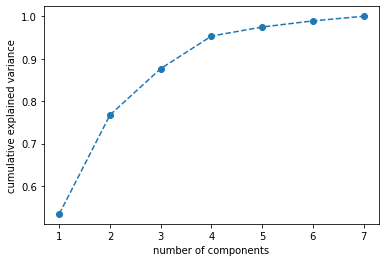

In [26]:
plt.plot(range(1,len(nongk_df.columns)+1),np.cumsum(evr),marker='o',linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

원래 dimension이 7이었는데
위 소스 코드의 핵심은 PCA의 파라미터 주성분 개수(n_components)를 결정하여 개수에 맞는 원래 데이터에서 변환된 주성분을 추출하는 것이다. 본 글에서는 주성분을 4개로 결정하였다. (분산이 제일 큰 놈 4개: 데이터가 널리 퍼진거)

This can be accomplished by instantiating a new PCA object with the n_components parameter set to 3.

The explained variance, or eigenvalue, in PCA shows the variance that can be attributed to each of the principal components.

In [27]:
for i, exp_var in enumerate(evr.cumsum()):
  print(i+1,"번째 분산량",evr[i], '\t','누적 분산량: ',exp_var)
  if exp_var >= 0.95:
      n_comps = i + 1
      break
print("Number of components:", n_comps)
# print(sum(evr,[]))
print(pca.explained_variance_ratio_)
pca = PCA(n_components=n_comps)
pca.fit(nongk_scaled)
nongk_scaled_pca = pca.transform(nongk_scaled)

1 번째 분산량 0.5340622533591339 	 누적 분산량:  0.5340622533591339
2 번째 분산량 0.23331979918533788 	 누적 분산량:  0.7673820525444718
3 번째 분산량 0.10916885512772596 	 누적 분산량:  0.8765509076721978
4 번째 분산량 0.07671527456626721 	 누적 분산량:  0.953266182238465
Number of components: 4
[0.53406225 0.2333198  0.10916886 0.07671527 0.02135    0.01443702
 0.01094679]


### Elbow Method for optimal value of k in KMeans

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the kneed KneeLocator

In [28]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데
# 이 지점의 K 값을 군집의 개수로 사용
# inertia_속성으로 확인할 수 있다.
# 클러스터 간 거리의 합을 나타내는 inertia value가 급격히 떨어지는 구간 이용
from kneed import KneeLocator
inertia_arr=[]
def elbow_point_for_k(nongk_scaled_pca):
  global inertia_arr
  k_range=range(2,15)
  for k in k_range:
    kmeans_pca=KMeans(n_clusters=k).fit(nongk_scaled_pca)
    inertia=kmeans_pca.inertia_
    inertia_arr.append(inertia)
    print('k value: ',k,'\t','cost: ',inertia)
  n_clusters = KneeLocator([i for i in k_range], inertia_arr, curve='convex', direction='decreasing').knee
  print("Optimal number of clusters", n_clusters)

In [32]:
elbow_point_for_k(nongk_scaled_pca)


k value:  2 	 cost:  70202.3842911643
k value:  3 	 cost:  55469.03930069745
k value:  4 	 cost:  46321.89470723468
k value:  5 	 cost:  41054.351869681486
k value:  6 	 cost:  37752.99448272843
k value:  7 	 cost:  34915.53122065576
k value:  8 	 cost:  32448.512345157287
k value:  9 	 cost:  30244.23111124854
k value:  10 	 cost:  28485.25041922751
k value:  11 	 cost:  27017.43977221962
k value:  12 	 cost:  25814.149131889302
k value:  13 	 cost:  24710.10914994125
k value:  14 	 cost:  23687.399958393424
Optimal number of clusters 5


In [33]:
inertia_arr
print(type(inertia_arr))

<class 'list'>


Text(0, 0.5, 'Average within-cluster sum-of-squares(inertia)')

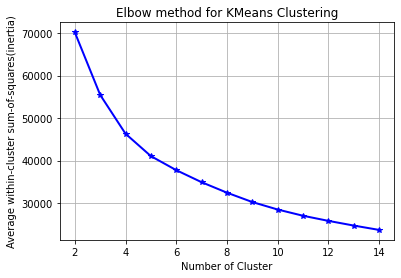

In [34]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(range(2,15),inertia_arr,'b*-',linewidth=2)
plt.grid(True)
# plt.vlines(KneeLocator([i for i in range(2,15)], inertia_arr, curve='convex', direction='decreasing').knee, ymin=min(inertia_arr), ymax=max(inertia_arr), linestyles='dashed')
plt.title('Elbow method for KMeans Clustering')
plt.xlabel('Number of Cluster')
plt.ylabel('Average within-cluster sum-of-squares(inertia)')

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the YellowBrick KElbowVisualizer

In [35]:
from yellowbrick.cluster import KElbowVisualizer

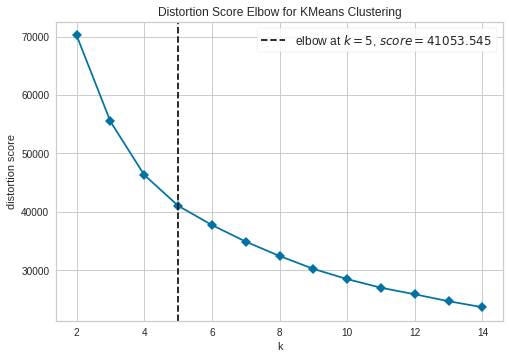

Optimal number of clusters: 5


In [36]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(2,15), timings=False)
visualizer.fit(nongk_scaled_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [41]:
number_of_clusters = 5
kmeanModel = KMeans(n_clusters = number_of_clusters ) 
kmeanModel.fit(nongk_scaled_pca)

KMeans(n_clusters=5)

In [ ]:
# nongk_rescaled['Name']=non_gk['Name']
# nongk_rescaled['Overall']=non_gk['Overall']
# nongk_rescaled['BestPosition']=non_gk['BestPosition']
# nongk_rescaled.insert(0,'Name',non_gk['Name'])
# nongk_rescaled.insert(1,'Club',non_gk['Club'])
# nongk_rescaled['Cluster']=kmeanModel.labels_

In [46]:
type(nongk_scaled_pca)

numpy.ndarray

In [42]:
labels=kmeanModel.labels_

In [56]:
nongk_pca_kmeans_df = pd.concat([nongk_df.reset_index(drop=True), pd.DataFrame(nongk_scaled_pca)], axis=1)
nongk_pca_kmeans_df.columns.values[(-1*n_comps):] = ["PCA Component " + str(i+1) for i in range(n_comps)]
nongk_pca_kmeans_df['Cluster'] = labels
nongk_pca_kmeans_df['Name']=non_gk['Name'].reset_index(drop=True)
nongk_pca_kmeans_df['BestPosition']=non_gk['BestPosition'].reset_index(drop=True)
nongk_pca_kmeans_df

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,Cluster,Name,BestPosition
0,3.43,2.80,1.20,3.15,3.67,-1.22,0.77,6.726875,0.342237,0.615166,0.181881,3,L. Messi,CAM
1,2.45,2.67,1.02,2.65,3.09,-1.15,2.02,5.816280,-0.336014,0.132669,1.394052,3,K. Benzema,CF
2,2.24,2.85,0.65,2.45,3.09,-0.85,2.82,5.701664,-1.078143,0.189942,1.999844,3,R. Lewandowski,ST
3,3.52,2.80,0.56,2.65,2.86,0.67,1.20,5.878852,-1.407581,0.854530,-0.417365,3,K. De Bruyne,CM
4,2.14,2.58,2.62,2.95,3.49,-1.07,1.76,6.356858,0.249218,-1.293110,0.964180,1,K. Mbappé,ST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16473,-1.16,-0.33,0.01,-1.33,-1.28,-1.25,-3.39,-2.358325,3.163213,0.651042,-1.205391,0,D. Collins,CAM
16474,-1.57,-1.29,-1.27,-1.83,-1.57,-0.16,-1.93,-3.583433,1.092952,0.832385,-0.595490,2,Yang Dejiang,CDM
16475,-0.73,-0.77,-0.36,-1.13,-1.40,-0.81,-2.52,-2.331546,2.086866,0.671840,-1.082719,0,L. Mullan,RM
16476,-3.06,-1.98,-1.50,-3.57,-2.75,0.10,-1.83,-6.079749,1.002441,0.339134,-0.071356,2,D. McCallion,CB


In [43]:
# nongk_pca_kclustered = nongk_scaled_pca
# # nongk_clustered['Cluster']=labels
# nongk_pca_kclustered['Name']=non_gk['Name'].reset_index(drop=True)
# nongk_pca_kclustered['BestPosition']=non_gk['BestPosition'].reset_index(drop=True)
# nongk_pca_kclustered.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
# nongk_pca_kclustered['Cluster'] = labels
# nongk_pca_kclustered.head()
# # nongk_clustered.insert(1,'BestPosition',non_gk['BestPosition']).reset_index(drop=True)
# # nongk_clustered.insert(2,'Cluster',labels).reset_index(drop=True)


IndexError: ignored

In [ ]:
# nongk_clustered['Cluster']=labels
# nongk_clustered[nongk_clustered['BestPosition'].isnull()]

In [57]:
nongk_pca_kmeans_df[nongk_pca_kmeans_df['Cluster']==4]

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,Cluster,Name,BestPosition
29,-0.24,-1.31,1.15,0.86,0.19,2.06,1.53,0.173179,-2.192184,-2.055017,-0.601848,4,K. Koulibaly,CB
47,-0.30,-0.78,0.88,0.71,0.36,2.05,2.28,0.438924,-2.643929,-1.898528,0.153084,4,M. Škriniar,CB
51,0.62,-0.40,0.15,-0.18,-0.13,1.92,1.20,0.018890,-2.197707,-0.660209,-0.526339,4,N. Süle,CB
87,-0.20,-1.39,-0.40,-0.53,0.13,2.01,1.83,-0.915996,-2.808926,-0.886914,0.068638,4,S. Savić,CB
102,-0.03,0.05,-0.26,-0.63,-0.07,1.96,1.95,-0.262966,-2.626102,-0.567875,0.458913,4,G. Chiellini,CB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,-0.61,-0.35,-0.13,-0.88,-0.56,-0.20,0.37,-1.112770,-0.039611,-0.255701,0.610716,4,M. Rahman,CAM
15727,-0.69,-0.85,-0.17,-0.48,-0.96,-0.16,-0.52,-1.524582,0.430633,-0.106373,-0.194307,4,O. Hammond,RM
15764,-0.81,-0.02,-1.64,-0.68,-0.56,-0.17,0.19,-1.381171,-0.299087,1.171067,0.862805,4,Dong Yu,ST
15838,-0.36,-0.72,-0.54,-0.28,-0.91,-0.23,-0.47,-1.277104,0.301133,0.339172,-0.172154,4,L. Schäfer,LM


In [58]:
# kmeans clustering의 문제점: 선수 능력치가 낮은 애들은 그냥 선수특성이고 나발이고 낮은 능력치 애들로 clustering됨

def show_cluster_samples(df, cluster_no, number_of_samples):
    return  df[df['Cluster'] == cluster_no][:number_of_samples]
for cluster_no in range(number_of_clusters):
    display(show_cluster_samples(nongk_pca_kmeans_df, cluster_no, 20))

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,Cluster,Name,BestPosition
3406,0.09,1.69,-3.24,0.66,0.19,-1.12,-1.53,0.242570,1.007407,3.936845,0.420762,0,R. Santa Cruz,ST
3579,-0.97,0.94,-1.54,0.31,0.50,-1.42,0.49,0.156907,0.540790,1.421077,1.930479,0,L. Pfeiffer,ST
3657,-1.08,0.72,-0.08,0.26,-0.19,-2.13,0.70,0.107245,1.351983,0.099337,2.142336,0,D. Dike,ST
3992,-1.22,1.21,-1.00,-0.28,1.39,-1.61,-0.35,0.355259,1.374019,1.155297,1.663378,0,Simy,ST
4021,-0.40,1.11,-1.45,-0.28,0.24,-1.46,0.47,0.103027,0.536712,1.507844,1.829305,0,M. Đurić,ST
4022,1.16,0.75,-0.08,1.31,-0.30,-1.25,-1.93,1.158376,1.951060,1.342770,-1.092103,0,Sávio,CAM
4088,-1.79,0.71,-1.36,0.51,0.22,-1.58,1.06,-0.223144,0.488325,0.884269,2.566642,0,A. La Mantia,ST
4109,-0.67,1.11,-0.08,-0.38,0.56,-1.85,0.19,0.439291,1.404555,0.353563,1.736602,0,I. Ramírez,ST
4138,-0.69,1.40,-1.64,0.61,-0.10,-1.19,-0.14,0.212966,0.781375,1.900249,1.328875,0,A. Cerri,ST
4230,-1.16,0.95,-0.08,0.61,0.47,-1.52,-0.10,0.514407,1.427474,0.301912,1.349399,0,M. Cóccaro,ST


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,Cluster,Name,BestPosition
4,2.14,2.58,2.62,2.95,3.49,-1.07,1.76,6.356858,0.249218,-1.293110,0.964180,1,K. Mbappé,ST
6,2.22,2.93,1.15,2.40,3.35,-1.36,2.02,5.887637,-0.088558,0.040198,1.684961,1,Cristiano Ronaldo,ST
9,2.92,2.60,1.70,3.20,3.32,-1.02,0.44,6.323095,0.627980,0.082362,-0.131042,1,Neymar Jr,LW
10,2.39,2.56,1.75,2.30,3.21,-0.74,0.84,5.619751,0.290989,-0.298451,0.295789,1,H. Son,LW
16,0.65,2.71,1.80,1.76,2.69,-0.51,2.39,4.594135,-0.443562,-1.184781,1.946045,1,E. Haaland,ST
33,0.85,2.50,1.52,1.76,2.40,-0.94,2.11,4.361989,-0.102262,-0.819436,1.886209,1,C. Immobile,ST
34,1.67,2.43,0.97,1.76,1.97,-1.09,1.50,4.269005,0.081458,0.034521,1.301281,1,R. Lukaku,ST
36,2.04,1.91,1.98,2.25,3.12,-0.40,0.40,5.063512,0.362448,-0.692652,-0.260671,1,R. Sterling,LW
37,2.41,2.39,1.11,2.80,2.78,-0.97,-0.05,5.301067,0.809534,0.534249,-0.231145,1,R. Mahrez,RW
43,2.14,2.01,2.16,2.50,2.75,-1.49,0.14,5.183788,1.353528,-0.570915,0.033943,1,K. Coman,LM


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,Cluster,Name,BestPosition
317,-0.83,-1.88,-0.54,-0.03,-1.11,1.77,1.55,-1.858921,-2.398845,-0.879955,-0.017618,2,R. Le Normand,CB
444,-1.06,-2.03,0.10,-0.73,-1.28,1.59,1.50,-2.283705,-2.035180,-1.544230,0.070163,2,Unai Núñez,CB
628,-0.19,-1.18,-3.28,-0.63,-0.45,1.54,0.59,-2.055438,-2.491215,2.097914,0.000549,2,G. Maripán,CB
738,-1.30,-1.91,0.51,-1.48,-0.71,1.41,2.61,-2.140516,-2.442256,-2.279435,1.117277,2,J. Aidoo,CB
792,-0.36,-1.29,-1.45,-0.63,-0.91,1.55,0.63,-1.922670,-1.960656,0.432855,-0.291907,2,Domingos Duarte,CB
834,-1.10,-0.51,-1.68,-0.28,-0.71,1.54,0.70,-1.680437,-1.826788,0.687902,0.229379,2,G. Pezzella,CB
900,0.05,-1.35,-1.00,-1.08,-1.05,1.54,0.63,-1.932366,-1.903462,0.095786,-0.471723,2,D. Zagadou,CB
918,-0.85,-1.51,-1.68,-0.43,-1.28,1.47,0.87,-2.353688,-2.038958,0.420143,0.024801,2,A. Disasi,CB
933,-1.24,-1.21,-0.22,-1.53,-0.42,1.55,1.81,-1.989117,-2.189402,-1.228440,0.804870,2,Vitor Hugo,CB
1011,-0.13,-1.31,-2.19,-0.28,-1.08,1.52,0.70,-1.923523,-2.227045,1.140046,-0.249944,2,Germán,CB


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,Cluster,Name,BestPosition
0,3.43,2.80,1.20,3.15,3.67,-1.22,0.77,6.726875,0.342237,0.615166,0.181881,3,L. Messi,CAM
1,2.45,2.67,1.02,2.65,3.09,-1.15,2.02,5.816280,-0.336014,0.132669,1.394052,3,K. Benzema,CF
2,2.24,2.85,0.65,2.45,3.09,-0.85,2.82,5.701664,-1.078143,0.189942,1.999844,3,R. Lewandowski,ST
3,3.52,2.80,0.56,2.65,2.86,0.67,1.20,5.878852,-1.407581,0.854530,-0.417365,3,K. De Bruyne,CM
5,2.31,2.70,1.98,2.65,3.52,-0.40,1.45,6.095835,-0.232463,-0.670677,0.525524,3,M. Salah,RW
7,1.49,0.70,1.02,1.06,1.22,2.21,2.30,2.563735,-2.884141,-1.184262,-0.216847,3,V. van Dijk,CB
8,2.43,2.92,-0.03,2.10,2.92,-0.52,2.32,5.290194,-1.217865,0.931740,1.592610,3,H. Kane,ST
11,1.90,1.48,-0.49,1.01,1.80,2.06,2.79,3.056038,-3.503582,0.319955,0.553757,3,Casemiro,CDM
12,2.04,2.15,2.02,2.45,3.26,-0.68,2.56,5.683272,-0.717845,-1.213182,1.398117,3,S. Mané,LM
13,2.84,1.53,0.01,2.10,2.66,1.81,2.44,4.564991,-3.169792,0.291899,-0.079556,3,J. Kimmich,CDM


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,Cluster,Name,BestPosition
29,-0.24,-1.31,1.15,0.86,0.19,2.06,1.53,0.173179,-2.192184,-2.055017,-0.601848,4,K. Koulibaly,CB
47,-0.30,-0.78,0.88,0.71,0.36,2.05,2.28,0.438924,-2.643929,-1.898528,0.153084,4,M. Škriniar,CB
51,0.62,-0.40,0.15,-0.18,-0.13,1.92,1.20,0.018890,-2.197707,-0.660209,-0.526339,4,N. Süle,CB
87,-0.20,-1.39,-0.40,-0.53,0.13,2.01,1.83,-0.915996,-2.808926,-0.886914,0.068638,4,S. Savić,CB
102,-0.03,0.05,-0.26,-0.63,-0.07,1.96,1.95,-0.262966,-2.626102,-0.567875,0.458913,4,G. Chiellini,CB
125,0.11,-1.06,1.52,0.11,0.91,1.95,2.23,0.645135,-2.505649,-2.476043,-0.037771,4,F. Tomori,CB
147,-0.34,-0.40,0.47,0.11,0.79,1.91,2.35,0.428040,-2.671275,-1.496038,0.573154,4,C. Romero,CB
152,0.54,-0.41,0.70,-0.18,0.70,1.79,2.09,0.671140,-2.520466,-1.421214,0.132855,4,R. Araujo,CB
156,-0.05,-0.61,0.19,-0.23,-0.42,1.94,2.11,-0.411475,-2.649227,-1.164368,0.258992,4,J. Giménez,CB
158,-0.46,-0.47,0.83,0.11,0.93,1.85,2.02,0.462111,-2.320390,-1.765839,0.350536,4,Bremer,CB


What is 3D PCA?
Most of the time, a PCA plot is a 2D scatter plot in which the data is plotted with two most descriptive principal components. However, you can choose to plot with three PCs instead, and this will create a 3D scatter plot, also called 3D PCA. 

The key difference between 2D PCA and 3D PCA is the number of principal components being selected for plotting. In PCA, principal components are constructed to capture the most variation in the dataset: PC1 describes the most variation, PC2 describes the second most variation, and so forth. As a result, the first two or three PCs can capture most of the variation and the rest can be discarded without losing much information. This can be seen in a scree plot.

In [63]:
type(nongk_pca_kmeans_df['Cluster'])

pandas.core.series.Series

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


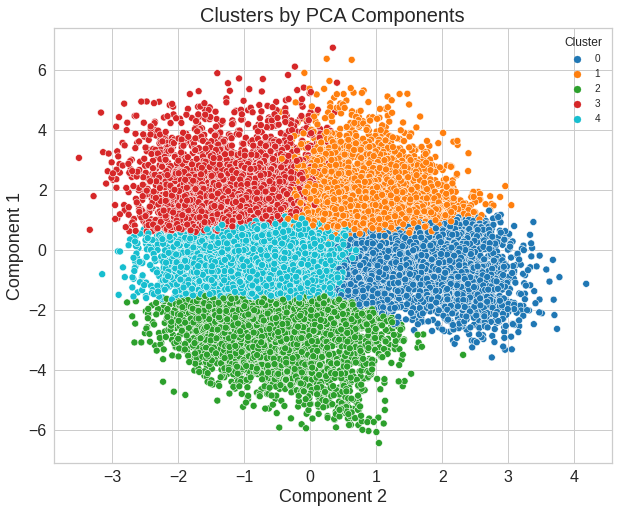

In [64]:
x = nongk_pca_kmeans_df['PCA Component 2']
y = nongk_pca_kmeans_df['PCA Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=nongk_pca_kmeans_df['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:cyan'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

KeyError: ignored

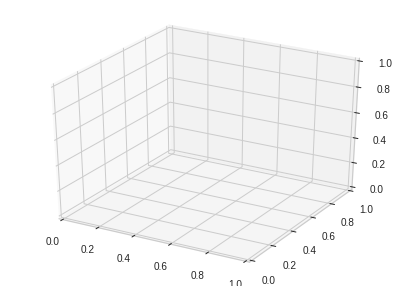

In [61]:
# Xax = nongk_pca_kmeans_df['PCA Component 1']
# Yax = nongk_pca_kmeans_df['PCA Component 2']
# Zax = nongk_pca_kmeans_df['PCA Component 3']
# y=labels


# cdict = {0:'red',1:'green',2:'royalblue',3:'violet',4:'gold'}
# labl = {0:'Cluster1',1:'Cluster2',2:'Cluster3',3:'Cluster4',4:'Cluster5'}
# marker = {0:'*',1:'o',2:'H',3:'d',4:'v'}
# alpha = {0:.3, 1:.5,2:.2,3:.4,4:.6}

# fig = plt.figure(figsize=(7,5))
# ax = fig.add_subplot(111, projection='3d')

# fig.patch.set_facecolor('white')
# for l in np.unique(y):
#  ix=np.where(y==l)
#  ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
#            label=labl[l], marker=marker[l], alpha=alpha[l])
# # for loop ends
# ax.set_xlabel("First Principal Component", fontsize=14)
# ax.set_ylabel("Second Principal Component", fontsize=14)
# ax.set_zlabel("Third Principal Component", fontsize=14)

# ax.legend()
# plt.show()